# Instructions

In today's lab, we will look into image similarity, considering a dataset of film posters which you can download from Blackboard.

By using this notebook server format, you have the assignments and instructions in one file, and you can dynamically update your code in your browser to play around with various parameters to see the effect.

As final deliverable to demonstrate your successful completion, please submit two text files through https://www.dropbox.com/request/KZGwmMXV9YeoNh1goKR5:
* 1. A text file named [YourName_ranking.txt] containing a top-10 ranking for a feature-similarity measure configuration you considered to be strong. Please specify the file according to the format indicated in the last cell on this page.
* 2. A text file named [YourName_reflection.txt] in which you explain why you thought this ranking was strong, and indicate what visual features you would wish to use or develop if you would like to do film genre classification based on visual poster features.

## Let's first get you going!
We will first import all necessary Python modules. Hit 'ctrl-enter' (or the 'run cell button') to execute the import statements in the cell below.

Before starting, import the lab utility modules from the https://github.com/mmc-tudelft/cs4065 project
by executing:
$ git clone https://github.com/mmc-tudelft/cs4065.git

If you are working locally, please open cs4065/datasets.py and modify the PATH_DATASETS variable
to point to the absolute path of the folder in which you unpacked the film posters.

Then restart the kernel through the top menu (Kernel > Restart)

In [1]:
# Import standard Python modules.
import numpy as np
import os
from pprint import pprint
import sys

# Import extra Python modules.
import cv2
import matplotlib.pyplot as plt
# Make matplotlib plot inline
%matplotlib inline 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

Please use git to pull some lab-specific utility code for our course, if you did not do this yet.

In [2]:
# Import modules from the https://github.com/mmc-tudelft/cs4065 project.

# If you are working on your local machine, uncomment the statement below
# and modify 'path/to/cs4065' to reflect the path to the cs4065 utility code folder.

sys.path.append('/Users/arkkadhiratara/Workspaces/cs4065')

# Furthermore, if you are working locally, please open cs4065/datasets.py and modify
# the PATH_DATASETS variable to point to the folder in which you unpacked the film posters.

from datasets import CS4065_Dataset
from cvtools import ipynb_show_color_histogram
from cvtools import ipynb_show_cv2_image
from cvtools import ipynb_show_matrix


We have to set some parameters to ensure compatibility with various possible OpenCV versions.

In [3]:
# Parameters.
try:
  _CV2_BGR2HSV = cv2.cv.CV_BGR2HSV
except:
  _CV2_BGR2HSV = cv2.COLOR_BGR2HSV

## Now, let's start!
Let's first load the dataset.

In [4]:
# Load dataset of images.
poster_images = CS4065_Dataset.get_poster_images()

We will now print the length of our poster array, and the path to the first image referred to in the array.

In [5]:
print len(poster_images)  # Number of images.
print poster_images[0]  # Path to the first image.

318
/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/10.000_Km.jpg


Now, let's see what this image looks like.

(321, 214, 3)


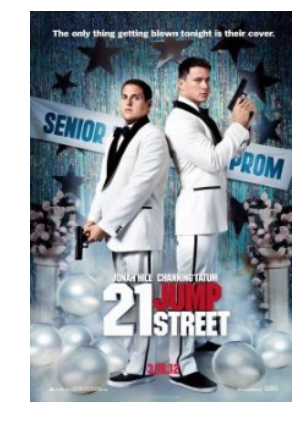

In [20]:
# Load and show an image.
image = cv2.imread(poster_images[2])
ipynb_show_cv2_image(image) # OpenCV is not as trivial with image display, but you can use our utility code for this.
print np.shape(image) # We verify the dimensions of this image.

## Question
What do these three printed numbers indicate?

## Drawing on the image
As you heard in the lecture, an image can be seen as a matrix. Let's modify some of the matrix values to draw rectangles in the poster.

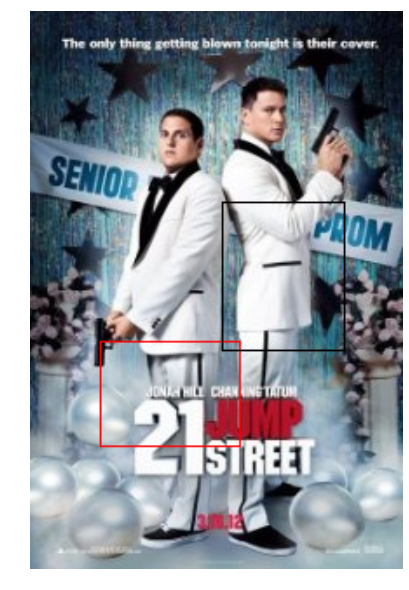

In [29]:
# Let's modify the image a little bit (see http://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html).
image_modified = image.copy()  # Don't forget to copy the image.
cv2.rectangle(image_modified, (40, 190), (120, 250), (0, 0, 255))  # OpenCV works with the BGR format (by default).
cv2.rectangle(image_modified, (110, 110), (180, 195), (0, 0, 0))
ipynb_show_cv2_image(image_modified, figsize=(10, 10))  # Use figsize to change the plot dimension.

## Question
Modify and rerun the code above to draw differently colored rectangles at different places in the image.

## Feature extraction
Now, we continue extracting features from the images.

In [33]:
# Extract global histogram features from images.

# First, define a function that extracts RGB histograms.
def compute_bgr_histogram(image, mask=None):
  histogram = cv2.calcHist(
      [image],  # List of images (in our case, just one).
      [0, 1, 2],  # List of channels to analyze.
      mask,  # Mask (optional).
      [8, 8, 8],  # Number of bins per channel.
      [0, 256, 0, 256, 0, 256]  # Range of each channel.
  )
  histogram_normalized = histogram.copy()
  cv2.normalize(histogram, histogram_normalized)
  return np.array(histogram_normalized).flatten()
  # return cv2.normalize(histogram).flatten()  # We want the histogram as a vector.


# Let's add a function for HSV histograms as well.
def compute_hsv_histogram(image, mask=None):
  hsv_image = cv2.cvtColor(image, _CV2_BGR2HSV)
  histogram = cv2.calcHist([hsv_image], [0, 1, 2], mask, [8, 8, 8], [0, 180, 0, 256, 0, 256]) # Note that H goes from 0 to 180.
  histogram_normalized = histogram.copy()
  cv2.normalize(histogram, histogram_normalized)
  return np.array(histogram_normalized).flatten()


# Again, we have to do some parameter configuration to ensure compatibility.
try:
  _CV2_BGR2HSV = cv2.cv.CV_BGR2HSV
except:
  _CV2_BGR2HSV = cv2.COLOR_BGR2HSV

# Question
Now, looking at the code in the cell above, write an own function in the cell below that computes a histogram only using the H and S values of the image.

In [36]:
# And another one for HS histograms (we are not obliged to use all the channels).
def compute_hs_histogram(image, mask=None):
  hs_image = cv2.cvtColor(image, _CV2_BGR2HSV)
  histogram = cv2.calcHist([hs_image], [0, 1], mask, [8, 8], [0, 180, 0, 256]) # Note exclude V.
  histogram_normalized = histogram.copy()
  cv2.normalize(histogram, histogram_normalized)
  return np.array(histogram_normalized).flatten()

# Compute histograms.
bgr_histogram = compute_bgr_histogram(image)
print np.shape(bgr_histogram)
hsv_histogram = compute_hsv_histogram(image)
print np.shape(hsv_histogram)

(512,)
(512,)


In [37]:
# Also compute your HS histogram: uncomment the lines below.
hs_histogram = compute_hs_histogram(image)
print np.shape(hs_histogram)

(64,)


Let's plot the histograms.

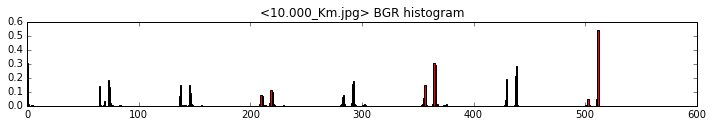

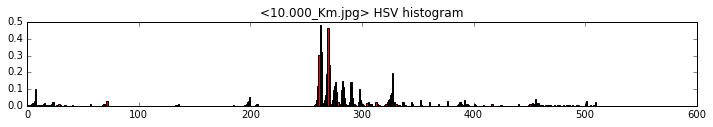

In [38]:
# Show histograms.
_, image_filename = os.path.split(poster_images[0])
ipynb_show_color_histogram(bgr_histogram, '<%s> BGR histogram' % image_filename)
ipynb_show_color_histogram(hsv_histogram, '<%s> HSV histogram' % image_filename)

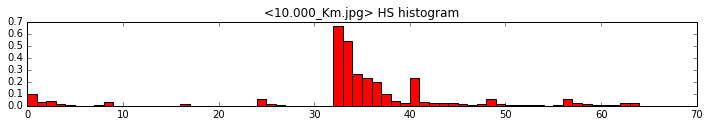

In [39]:
# Also do this for your HS histogram.
ipynb_show_color_histogram(hs_histogram, '<%s> HS histogram' % image_filename)

## Feature computation for the whole dataset
How to these features influence the way in which images are related to one another?

We will compute features for each of our items in the dataset, and then build a (dis)similarity matrix.

In [13]:
# Let's compare all the images by building a feature matrix and a (dis-)similarity one.

# We will try different features.
feature_extractors = {
    'BGRhist': (compute_bgr_histogram, 512),  # Pointer to function, feature space dimensionality.
    'HSVhist': (compute_hsv_histogram, 512),
    # uncomment the line below for your own HS histogram
    #'HShist': (compute_hs_histogram, 144),
}

# Let's compute the feature matrices.
number_of_images = len(poster_images)
feature_matrices = {}

# We iterate over the various features and compute the feature vectors.
for feature_name in feature_extractors:
  print 'computing %s feature matrix' % feature_name
  (feature_extractor, feature_space_dimensionality) = feature_extractors[feature_name]

  # Initialize matrix.
  feature_matrices[feature_name] = np.zeros(
      (number_of_images, feature_space_dimensionality), np.float32)

  # Compute feature vectors.
  for index, image_path in enumerate(poster_images):
    image = cv2.imread(image_path)
    feature_matrices[feature_name][index, :] = feature_extractor(image)

  # Show statistics.
  print ' - size', np.shape(feature_matrices[feature_name])
  print ' - min: %.3f' % np.min(feature_matrices[feature_name])
  print ' - max: %.3f' % np.max(feature_matrices[feature_name])

computing HSVhist feature matrix
 - size (318, 512)
 - min: 0.000
 - max: 0.998
computing BGRhist feature matrix
 - size (318, 512)
 - min: 0.000
 - max: 0.999


## Computing distances
Now, we are going to compute the distances between the items in our dataset.

computing distance matrix (metric: HSVhist, feature: intersection_area)
computing distance matrix (metric: BGRhist, feature: intersection_area)
computing distance matrix (metric: HSVhist, feature: euclidean)
computing distance matrix (metric: BGRhist, feature: euclidean)


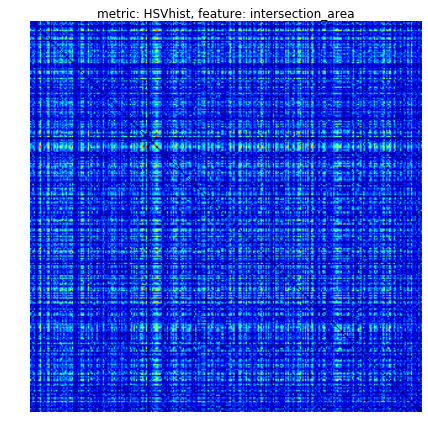

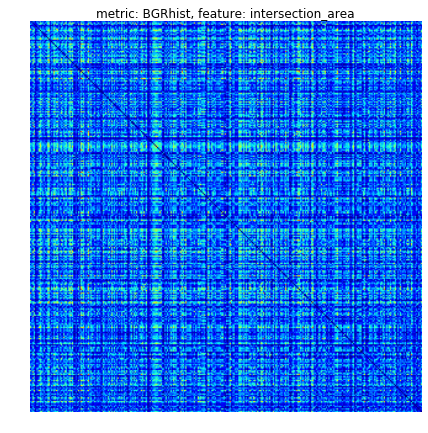

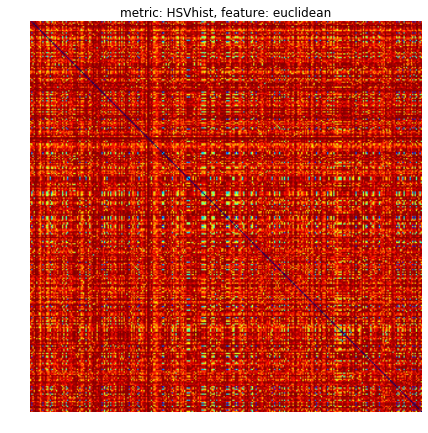

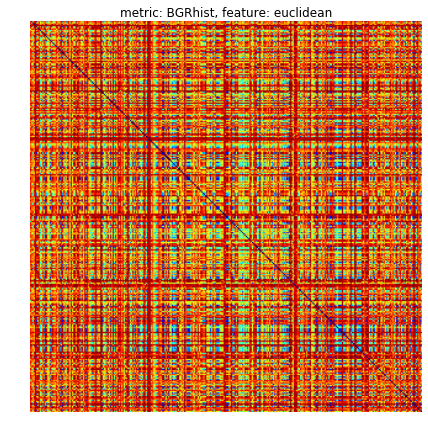

In [14]:
# We will try different feature vector distance metrics.
features_distance_metrics = {
    'euclidean': 'euclidean',  # Or lambda u, v: np.sqrt(((u-v)**2).sum()) (slower).
    'intersection_area': lambda u, v: np.sum(np.min([u, v], 0)),  # NB: this is a similarity metric.
    # you can expand this list with own implementation of metrics, or references to metrics in scipy
    # (see scipy.distance.pdist reference below)
}

# Let's compute the distance matrices.
distance_matrices = {}
for distance_metric_name in features_distance_metrics:
  distance_matrices[distance_metric_name] = {}
  for feature_name in feature_extractors:
    plot_title = 'metric: %s, feature: %s' % (feature_name, distance_metric_name)
    print 'computing distance matrix (%s)' % plot_title
    
    # Compute the distance matrix using scipy.distance.pdist
    # (see http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.spatial.distance.pdist.html).
    distance_matrices[distance_metric_name][feature_name] = squareform(pdist(
        feature_matrices[feature_name], features_distance_metrics[distance_metric_name]))

    # Check the size.
    assert np.shape(distance_matrices[distance_metric_name][feature_name])[0] == number_of_images

    # Plot.
    ipynb_show_matrix(distance_matrices[distance_metric_name][feature_name], plot_title)
    

## Question
What do these plotted matrices indicate? What do red/blue colors indicate?

Let's now examine the distance matrices in more detail.

selected image: <Andaz_Apna_Apna.jpg>
 - metric: HSVhist, feature: intersection_area
  top #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Andaz_Apna_Apna.jpg>
  top #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Prometheus.jpg>
  top #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Interstellar.jpg>
  bottom #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Mrs._Doubtfire.jpg>
  bottom #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Pulp_Fiction.jpg>
  bottom #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Divergent.jpg>
 - metric: BGRhist, feature: intersection_area
  top #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Andaz_Apna_Apna.jpg>
  top #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Prometheus.jpg>
  top #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/There_Will_Be_Blood.jpg>
  bottom #0: </Users/ar

/Users/arkkadhiratara/anaconda/envs/opencv/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


  top #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/A_Little_Chaos.jpg>
  bottom #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/The_Little_Mermaid.jpg>
  bottom #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Frozen.jpg>
  bottom #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/A_Bug's_Life.jpg>
selected image: <The_Expendables_3.jpg>
 - metric: HSVhist, feature: intersection_area
  top #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/The_Expendables_3.jpg>
  top #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Rocky_Balboa.jpg>
  top #2: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Oorlogswinter.jpg>
  bottom #0: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Guardians_of_the_Galaxy.jpg>
  bottom #1: </Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/21_Jump_Street.jpg>
  bottom #2: </Users/arkkadhiratara/Workspaces/cs

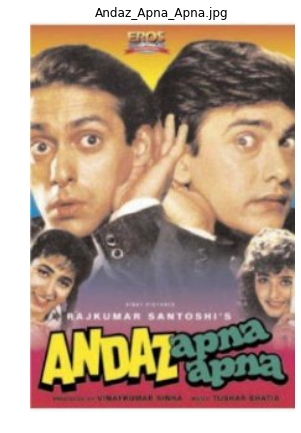

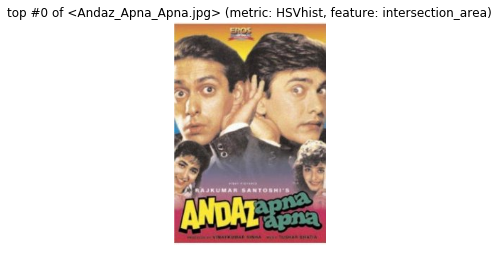

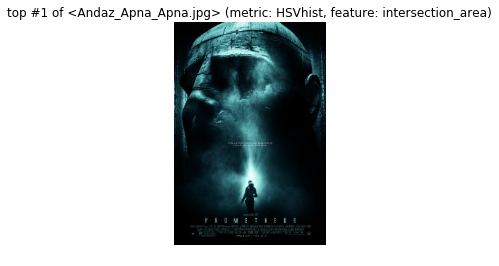

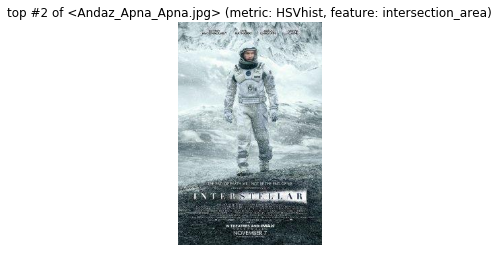

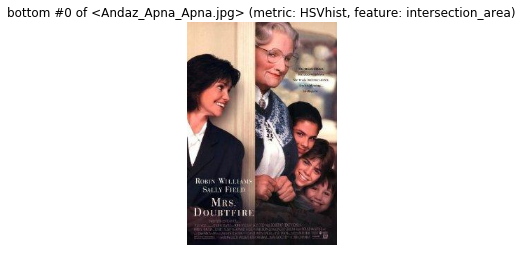

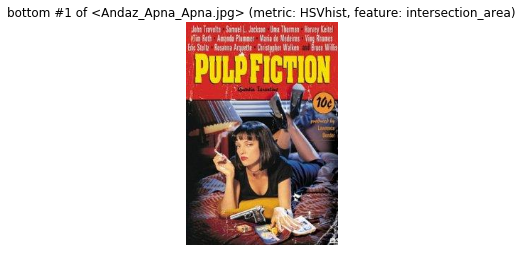

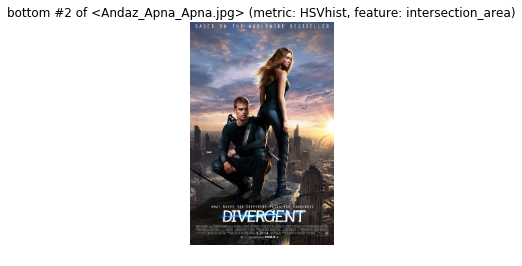

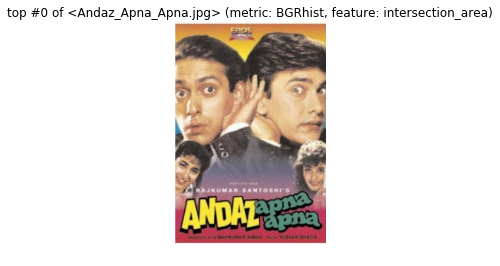

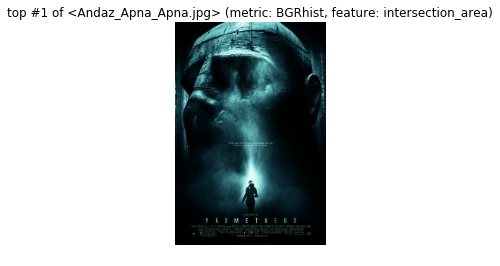

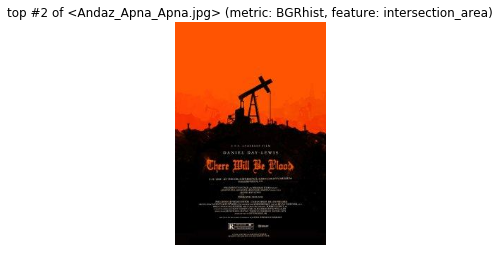

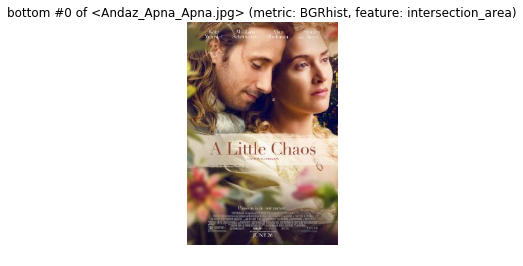

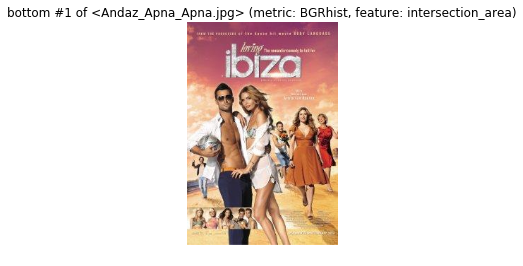

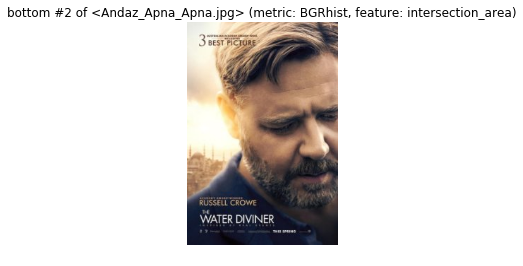

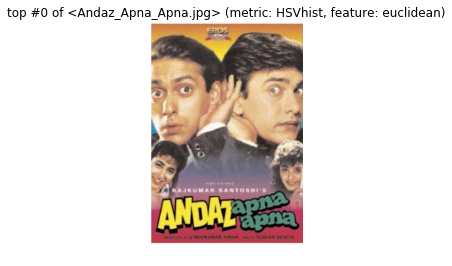

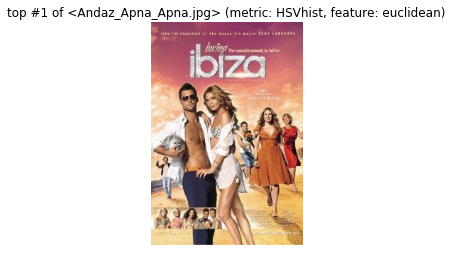

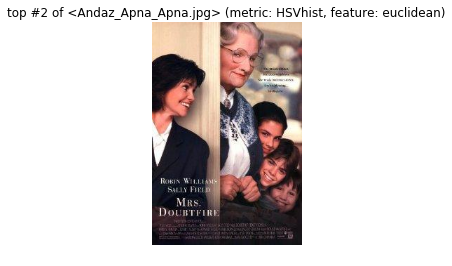

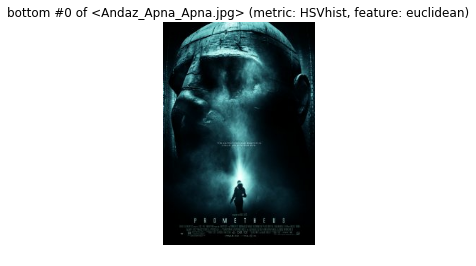

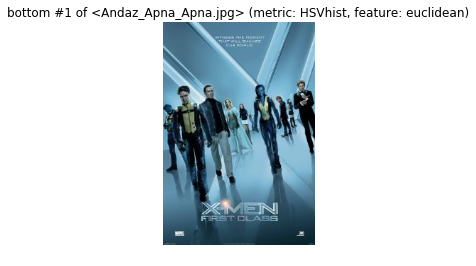

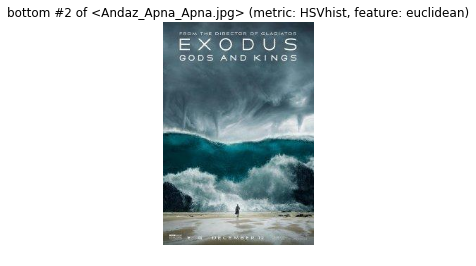

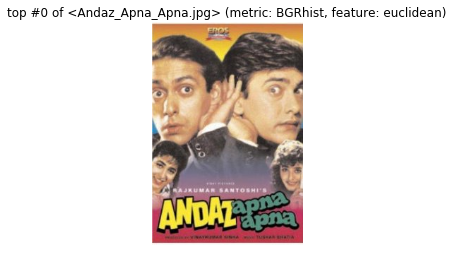

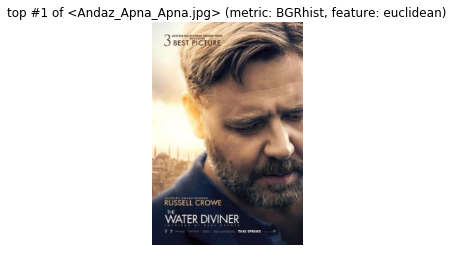

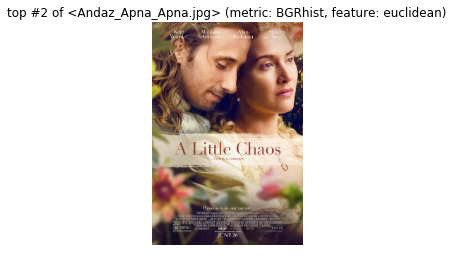

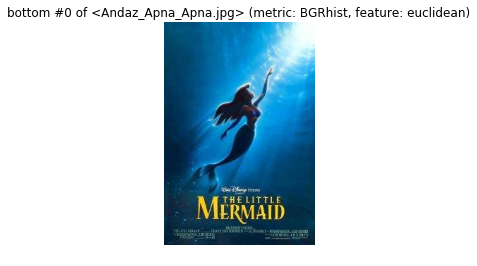

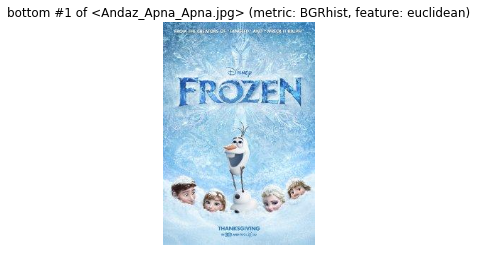

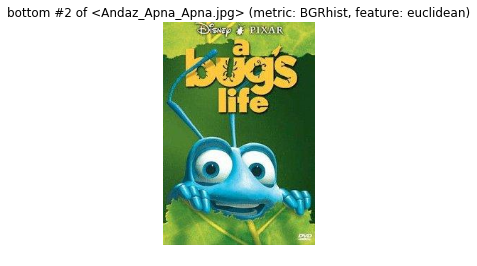

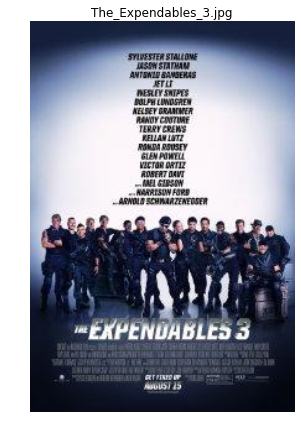

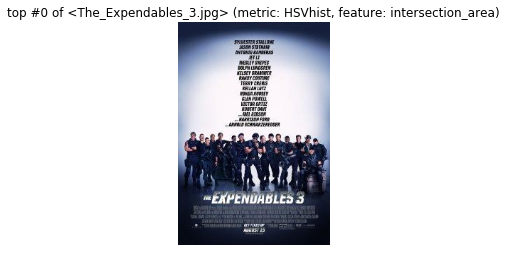

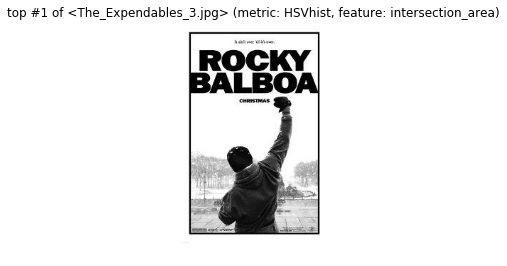

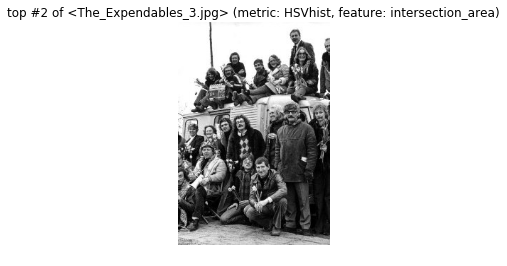

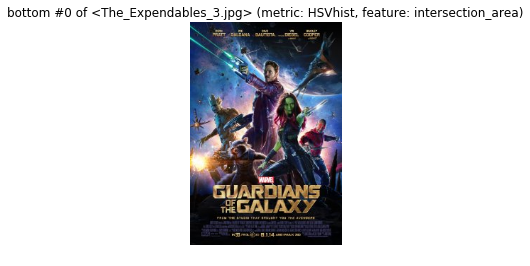

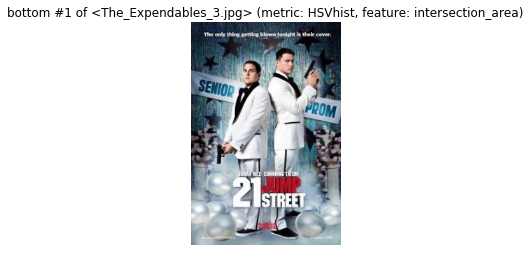

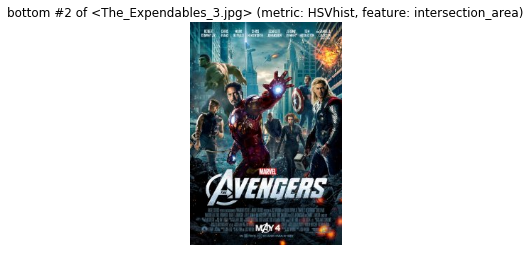

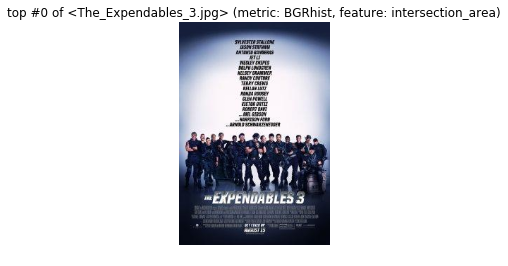

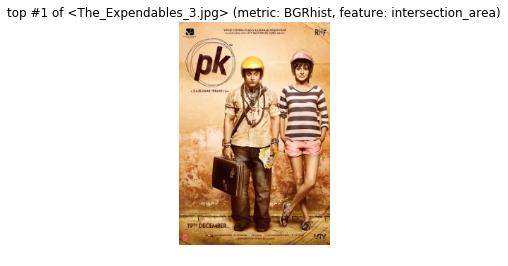

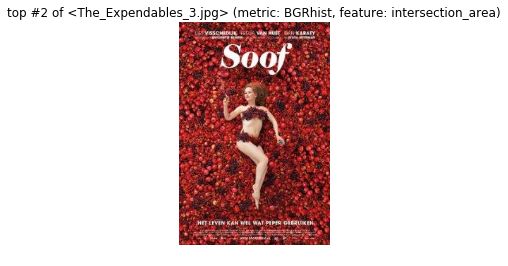

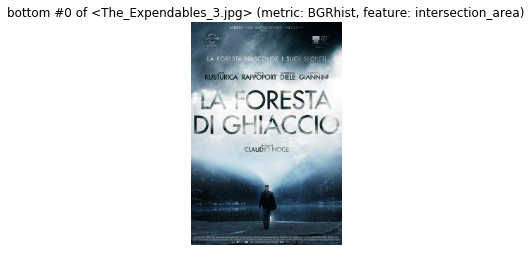

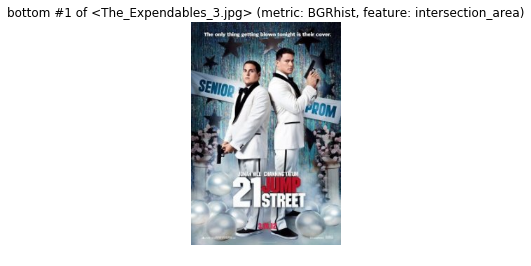

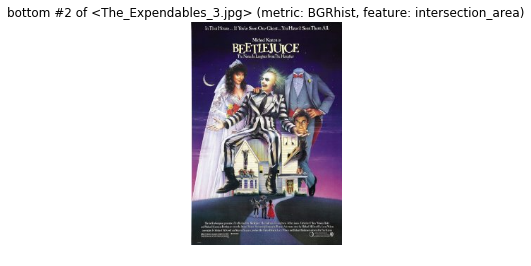

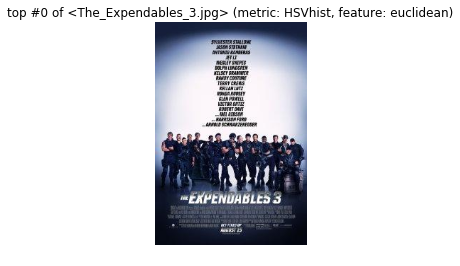

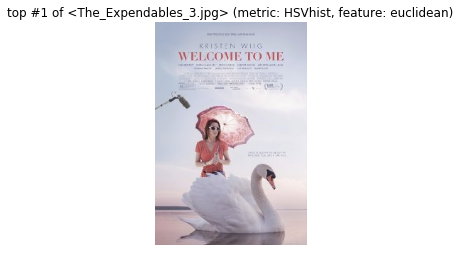

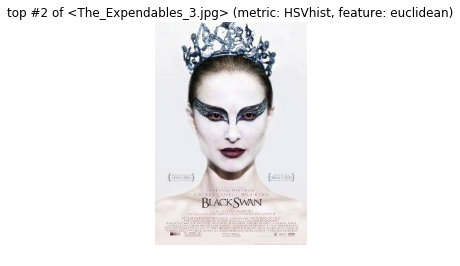

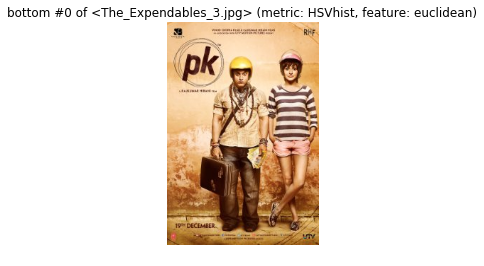

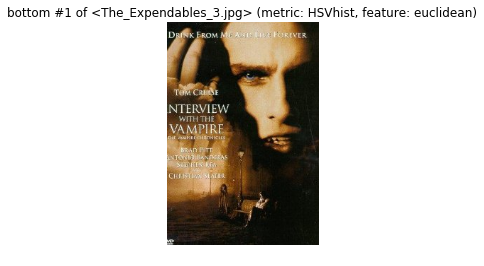

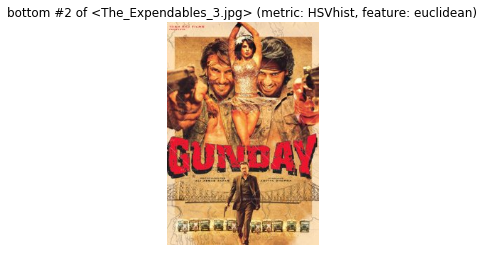

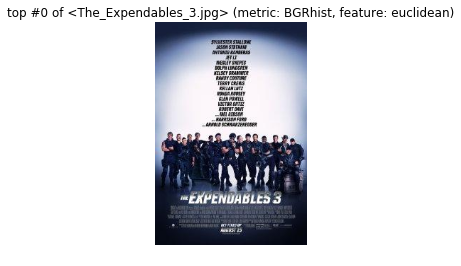

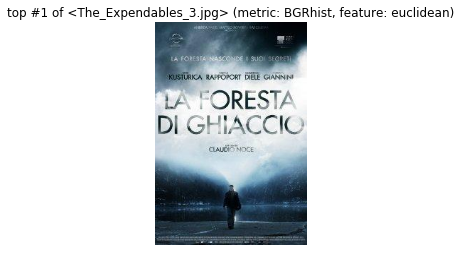

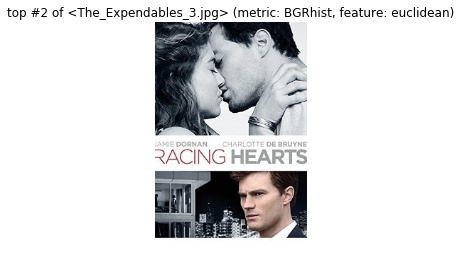

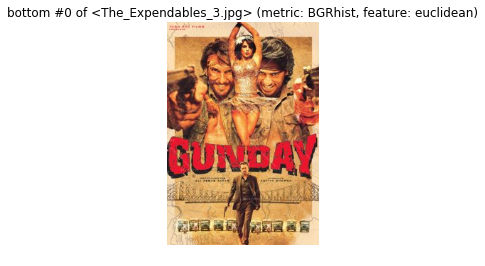

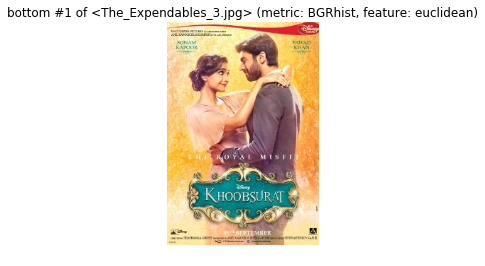

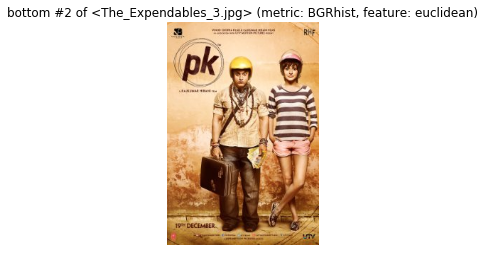

In [15]:
# Let's use the distance matrices to find the nearest/farthest items for a number of random images.
number_of_random_images = 2
number_of_examples_per_image = 3

# Choose random images.
random_image_indexes = np.random.randint(0, number_of_images, number_of_random_images)

# Show nearest/farthest items.
for random_image_index in random_image_indexes:
  _, reference_image_name = os.path.split(poster_images[random_image_index])
  print 'selected image: <%s>' % reference_image_name
  reference_image = cv2.imread(poster_images[random_image_index])
  ipynb_show_cv2_image(reference_image, reference_image_name)
  for distance_metric_name in features_distance_metrics:
    for feature_name in feature_extractors:
      plot_base_title = 'metric: %s, feature: %s' % (feature_name, distance_metric_name)
      print ' - %s' % plot_base_title

      # Extract the pairwise scores for the current image.
      pairwise_scores = distance_matrices[distance_metric_name][feature_name][random_image_index, :]

      # Get the indexes sorted by score.
      pairwise_scores_sorted_indexes = np.argsort(pairwise_scores)

      # Find the top k and the bottom k images.
      top_k_indexes = pairwise_scores_sorted_indexes[:number_of_examples_per_image]
      bottom_k_indexes = reversed(pairwise_scores_sorted_indexes[-number_of_examples_per_image:])

      # Show top k images.
      for i, image_index in enumerate(top_k_indexes):
        print '  top #%d: <%s>' % (i, poster_images[image_index])
        image = cv2.imread(poster_images[image_index])
        ipynb_show_cv2_image(image, 'top #%d of <%s> (%s)' % (
            i, reference_image_name, plot_base_title), figsize=(4, 4))
        
      # Show bottom k images.
      for i, image_index in enumerate(bottom_k_indexes):
        print '  bottom #%d: <%s>' % (i, poster_images[image_index])
        image = cv2.imread(poster_images[image_index])
        ipynb_show_cv2_image(image, 'bottom #%d of <%s> (%s)' % (
            i, reference_image_name, plot_base_title), figsize=(4, 4))


## Question
Can you explain why results end up in the top or bottom of the list?

## Final Assignment
Please play around with a few more distance metrics (and, if you are enthusiastic, a few more feature vectors--feel free to explore the possibilities of OpenCV).

This mostly would require you to reconfigure parts of the code above.

Then, as soon as you have a ranking you like, run the code below to generate a formatted overview of your results.
Copy the console output into a text file, save the file as [YourName_ranking.txt], and upload this to the Dropbox link given on top of the page.


In [16]:
# generate a formatted list of top-10 ranked results.
# replace the placeholder texts below with your name and a one-line explanation of your approach.
print 'name: %s' % 'REPLACE_THIS_WITH_YOUR_NAME'
print 'approach: %s' % 'GIVE_A_ONE_LINE_EXPLANATION_OF_YOUR_APPROACH_HERE'

# now print the top-10.
top_k_indexes = pairwise_scores_sorted_indexes[:10]
for i, image_index in enumerate(top_k_indexes):
    print '%d.\t%s' % (i, poster_images[image_index])

name: REPLACE_THIS_WITH_YOUR_NAME
approach: GIVE_A_ONE_LINE_EXPLANATION_OF_YOUR_APPROACH_HERE
0.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/The_Expendables_3.jpg
1.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/La_foresta_di_ghiaccio.jpg
2.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Flying_Home.jpg
3.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Begin_Again.jpg
4.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Let's_Be_Cops.jpg
5.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/The_Great_Escape.jpg
6.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Alexander_and_the_Terrible,_Horrible,_No_Good,_Very_Bad_Day.jpg
7.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Wassup_Rockers.jpg
8.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Valkyrie.jpg
9.	/Users/arkkadhiratara/Workspaces/cs4065/datasets/poster_images/Selma.jpg
